<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Aplica%C3%A7%C3%A3o_flux_1_schnell_%5BDiffusion_Model%5D_no_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aplicação do Flux [schnell] via Google Colab

Adaptado por [A.Belem](mailto:andrebelem@id.uff.br) a partir do original de [Camenduru](https://github.com/camenduru/flux-jupyter/blob/main/README.md)<br>
24.Set.2024<br>

Este código configura um pipeline do [Flux [schnell]](https://huggingface.co/black-forest-labs/FLUX.1-schnell) para geração de imagens utilizando modelos pré-treinados (UNET, CLIP e VAE) em um ambiente de Deep Learning *dentro do google colab* (Isso mesmo ! Uhuu!). Os modelos são carregados no Google Colab a partir do repositório GitHub e do Hugging Face e utiliza modelos de difusão para gerar imagens baseadas em entradas textuais, como parte de uma interface ou sistema chamado "TotoroUI".

Ele foi adaptado com base nos notebooks disponívels em [flux-jupyter](https://github.com/camenduru/flux-jupyter/blob/main/README.md), com pequenas modificações e uma vasta quantidade de explicações. Use com inteligência !


**Tenha paciência**: essa operação inicial pode demorar um pouco (uns 3 minutos).

In [1]:
# Primeiro, clona o conteúdo do TotoroUI para dentro da VM colab via ComfyUI
# descomente a linha abaixo se você não precisa ver as msgs de saida.
#%%capture
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.27.post2
!apt -y install -qq aria2 #<-- vou usar o aria2 para baixar os modelos pré-treinados

## Obs: não se preocupe com algumas msg de erro no aria2, e na incompatibilidade de versões do xformers !!

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 13250, done.
remote: Total 13250 (delta 0), reused 0 (delta 0), pack-reused 13250 (from 1)
Receiving objects: 100% (13250/13250), 7.23 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (8956/8956), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s et

### Usando o ComfyUI

Note que usamos o ComfyUI, que é uma interface gráfica, para facilitar o uso e a manipulação de modelos de difusão (diffusion models), que são utilizados para gerar imagens a partir de descrições textuais, conhecidos por serem a base de muitas das tecnologias de IA generativa. Ele oferece uma maneira mais acessível para pesquisadores e desenvolvedores manipularem e testarem esses modelos sem a necessidade de codificação profunda. O ComfyUI permite o controle sobre o fluxo de trabalho de difusão e é amplamente utilizado em projetos de geração de imagens.  <br>

O **Totoro3** é uma versão personalizada do ComfyUI, que pode conter ajustes ou funcionalidades específicas voltadas para um projeto ou objetivo particular, como a geração de imagens com maior controle ou otimização de fluxos de trabalho.


Agora vou baixar os modelos de aprendizagem....(e isso também pode demorar um pouco).

In [2]:
# agora, usando o aria2 (https://aria2.github.io/), baixa os arquivos de modelos de aprendizado profundo (UNET, VAE, CLIP) do repositório da Hugging Face
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/black-forest-labs/FLUX.1-schnell/resolve/main/flux1-schnell.safetensors -d /content/TotoroUI/models/unet -o flux1-schnell.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors


 *** Download Progress Summary as of Tue Sep 24 22:56:41 2024 *** 
=
[#e15859 11GiB/22GiB(53%) CN:16 DL:217MiB ETA:48s]
FILE: /content/TotoroUI/models/unet/flux1-schnell.safetensors
-

 *** Download Progress Summary as of Tue Sep 24 22:57:41 2024 *** 
=
[#e15859 21GiB/22GiB(95%) CN:16 DL:192MiB ETA:5s]
FILE: /content/TotoroUI/models/unet/flux1-schnell.safetensors
-


Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
e15859|OK  |   182MiB/s|/content/TotoroUI/models/unet/flux1-schnell.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
5caaaa|OK  |   224MiB/s|/content/TotoroUI/models/vae/ae.sft

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
9b7a6d|OK  | 

### Agora a importação de módulos e inicialização de componentes

A próxima etapa importa bibliotecas como torch (PyTorch), numpy (operações com arrays) e PIL (manipulação de imagens) e inicializa componentes do repositório clonado, incluindo os pedaços abaixo:
- DualCLIPLoader, usado para processar descrições textuais e associá-las a imagens.
- UNETLoader, usado para modelos de difusão, gerando a imagem.
- RandomNoise, BasicGuider, KSamplerSelect, que são componentes customizados que auxiliam no processo de geração de imagens.
- VAELoader, VAEDecode, usados para codificar e decodificar imagens latentes (representações comprimidas das imagens).

Depois disso, usamos o *Modo de Inferência*, onde a função `torch.inference_mode()` desativa o cálculo de gradientes, acelerando a inferência e reduzindo o consumo de memória. Além disso, o código carrega o modelo CLIP, o modelo UNET e o VAE utilizando os pesos previamente baixados. Por último, a função
`closestNumber` encontra o número mais próximo de `n` que seja múltiplo de `m` (traduzindo: uma operação de arredondamento e ajustes em valores durante o processamento) e é usado no processo de criação.


Obs: Alguns ajustes no código ainda precisam ser feitos pois há uma atualização do torch e novas funções, mas, apenas ignore os warnings. O tempo de inicialização é de 2 minutos.

In [3]:
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-schnell.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/tra

## MÁGICA !!!

Para usar o flux, basta escrever o seu promtp na variável `positive_prompt` e eventualmente ajustar o tamanho da imagem em `width` e `height`. E tenha paciência para ver o resultado. Afinal, você está criando imagens apenas com um prompt ! Porém, como a maioria dos modelos são treinados em inglês, você terá que usar o prompt em inglês.

  0%|          | 0/4 [00:00<?, ?it/s]

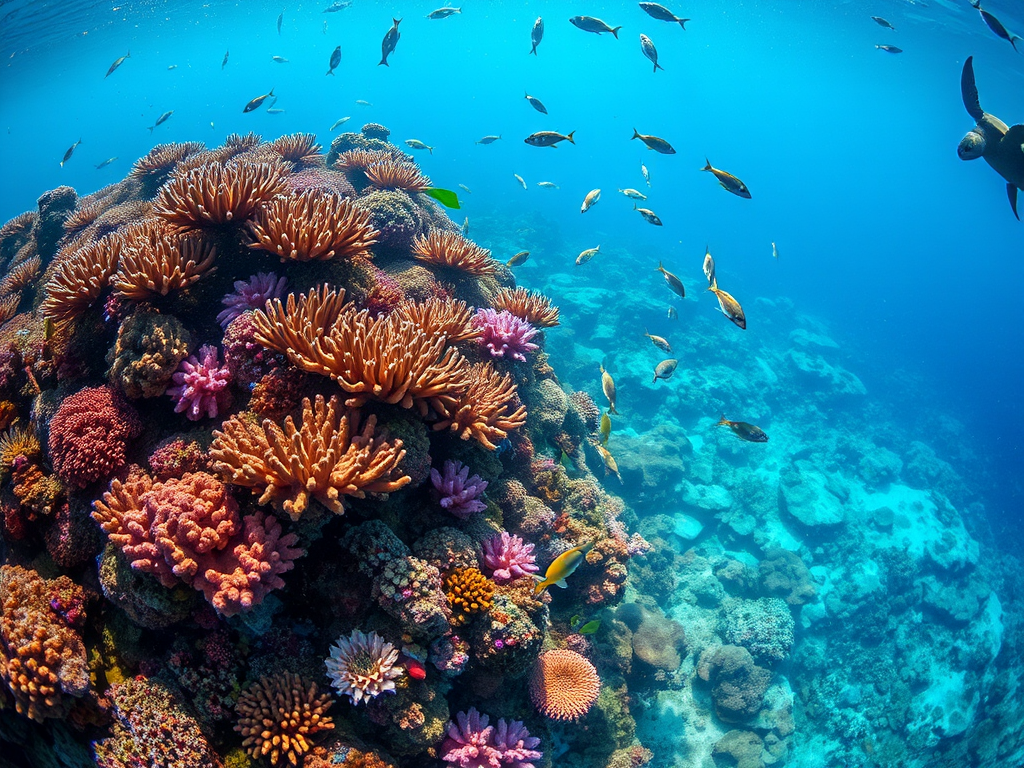

In [8]:
with torch.inference_mode():
    positive_prompt = "A underwater image of a coral reef, with multicolored fish and a turtle"
    width = 1024
    height = 768
    seed = 0
    steps = 4
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    #print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

### Considerações

**Dependência do Treinamento do Modelo**<br>

A maioria dos modelos de geração de imagens, como aqueles baseados em CLIP (que mapeia texto para imagens) ou outros modelos de difusão, é treinada usando corpora extensos em inglês. Esses modelos tendem a ser mais precisos e gerar imagens de maior qualidade quando o prompt está em inglês, simplesmente porque têm uma maior exposição a descrições e associações neste idioma.

Exemplo: Se você descrever uma paisagem complexa em inglês, o modelo provavelmente gerará resultados mais próximos da realidade, pois foi treinado com milhões de exemplos semelhantes em inglês. Alguns modelos mais recentes, como aqueles desenvolvidos pela Hugging Face ou outras empresas que têm suporte multilingue, também foram treinados em múltiplos idiomas, incluindo o português. No entanto, mesmo esses modelos podem ter um desempenho levemente inferior quando comparados com o inglês, dependendo da quantidade e da qualidade dos dados de treinamento em português.

**Tradução Automática Implícita**<br>

Em alguns casos, quando o prompt está em português, o modelo pode "traduzir" implicitamente o texto para inglês antes de gerar a imagem. Isso pode levar a pequenos erros de interpretação ou nuances perdidas na tradução. Por exemplo, palavras como "verde" podem ser corretamente interpretadas, mas termos mais específicos ou regionais podem ser traduzidos incorretamente ou gerar resultados inesperados.

**Precisão e Detalhes Específicos**<br>

Em inglês, os resultados costumam ser mais precisos, especialmente em descrições complexas, pois os modelos CLIP e UNET têm um melhor mapeamento semântico para descrições visuais detalhadas em inglês. Em português, você ainda pode obter bons resultados, mas a riqueza dos detalhes pode ser afetada, dependendo da familiaridade do modelo com termos específicos.



### APROVEITE !